<a href="https://colab.research.google.com/github/hellocybernetics/practice_pystan/blob/master/gaussian_process_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan

    100% |████████████████████████████████| 50.0MB 762kB/s 
    100% |████████████████████████████████| 2.1MB 13.4MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import seaborn
from scipy.stats import mstats
%matplotlib inline

### ガウシアンプロセスサンプラー
下記の式に従ってサンプリングを行うガウシアンプロセスサンプラー。

#### 共分散関数

$$
{K(x|α,ρ)_{i,j} =α^2\exp\Big(−\frac{1}{2ρ^2} \sum_{d=1}^D(x_{i,d} −x_{j,d})^2\Big)
}
$$

　
 
において、$a = 1$, $\rho=1$ を適用し、

　
 
$$
{K(x|1,1)_{i,j} =\exp\Big(−\frac{1}{2} \sum_{d=1}^D(x_{i,d} −x_{j,d})^2\Big)
}
$$

　
 
とした共分散関数を利用します。ここで $i, j$ はそれぞれデータ数方向のindexであり、$d$ はベクトル型データの次元方向のindexです。

#### 平均関数
平均関数は $ 0$ ベクトルを利用します。

#### ガウシアンプロセスサンプラー
下記のガウシアンプロセスサンプラーを用います。 


　


$$
\begin{align}
f(x) & =\mathcal {GP} ({0}, K(x | \alpha, \rho)) \\
y &\sim \mathcal N(f(x), 0.3)
\end{align}
$$

　


ちなみに実際にサンプリングするときは有限の数のデータ $x$ を利用するので $\mathcal f(x) = {GP}$ を二番目の式に代入してしまって、確率分布の計算を考えた場合には

　
 
$$
y \sim \mathcal N({0}, K(x | \alpha, \rho) + 0.3I)
$$

　
 
となることろ利用します。$I$ は単位行列で、元々の二番目の式の分だけ分散が大きくなる（共分散は変わらない）という雰囲気だけ…。

In [0]:
stan_model = """
data {
  int<lower=1> N;
  real x[N];
}

transformed data {
  matrix[N, N] K = cov_exp_quad(x, 1.0, 1.0);
  vector[N] mu = rep_vector(0, N);
  for (n in 1:N) 
    K[n, n] = K[n, n] + 0.3;
}

parameters {
  vector[N] y;
}

model {
  y ~ multi_normal(mu, K);
}
"""

In [15]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66b01db10e2bf62035a80c81f7695a54 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmptyp_p_up/stanfit4anon_model_66b01db10e2bf62035a80c81f7695a54_4329639226961591462.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
x_data = np.linspace(-5, 5, 50)
N_data = x_data.shape[0]
y_sample = sm.sampling(iter=500, warmup=100, chains=3, seed=1992, 
                       data={'N': N_data, 'x': x_data})

In [0]:
y_data = y_sample.extract("y")["y"]

#### サンプルを可視化
合計で1200個のサンプルが得られました。

適当に何個かを選んで見てみましょう。

In [18]:
y_data.shape


(1200, 50)

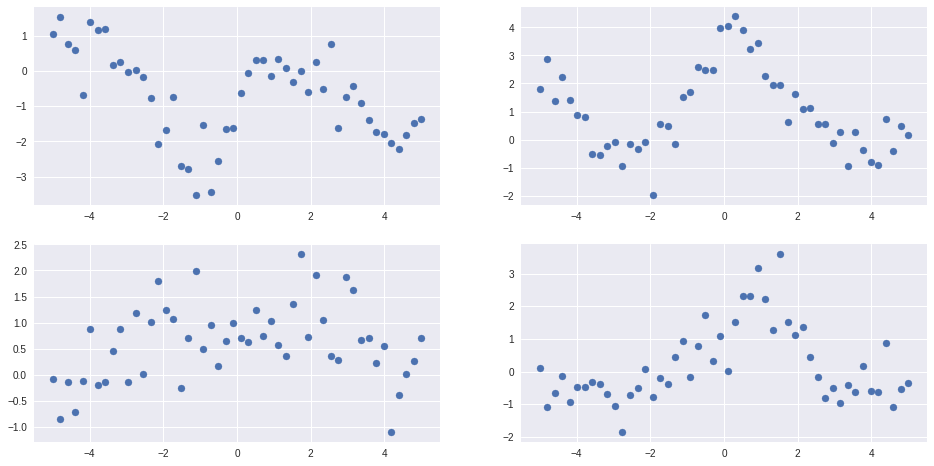

In [29]:
plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(x_data, y_data[i, :])

### ガウシアンプロセス回帰
上記のガウシアンプロセスサンプラーでは勝手に共分散関数 $K(x|\alpha, \rho)$ を勝手に決めて、サンプリングを行いました。実際のデータの生成プロセスは、まさかこんな再生核ヒルベルト空間を介して出てきているわけがありませんので、これは単にガウシアンプロセスを見るための例題です。もう一度式を見ましょう。


　
 
 $$
\begin{align}
f(x) & =\mathcal {GP} ({0}, K(x | \alpha, \rho)) \\
y &\sim \mathcal N(f(x), 1)
\end{align}
$$


 　
  
  
 
 重要なのは、何らかの生成プロセスを通して観測したデータ $(x, y)^N$ に対して、ガウシアンプロセスで回帰を行う場合は、共分散関数 $\alpha, \rho$ を上手く調整ししてやることになります（なぜならガウシアンプロセスサンプラーが発生するデータは、これらのパラメータに依存しているため）。
 
 より一般的には、観測時のノイズ もパラメータ化して
 
 　
  
 $$
\begin{align}
f(x) & =\mathcal {GP} ({0}, K(x | \alpha, \rho)) \\
y &\sim \mathcal N(f(x), \sigma^2)
\end{align}
$$

　
 
 とします。更に事前分布としてパラメータには下記のような分布を敷いておきましょう。特に何も仮定したくなければ無情報事前分布を敷いておけばいいです。
 
 　
 
 $$
 \begin{align}
 \rho &\sim \mathcal {InvGamma} (1, 1) \\
 \alpha & \sim \mathcal N(0, 1) \\
 \rho & \sim \mathcal N(0, 1) \\
 \end{align}
 $$
 
 　
  
  

In [0]:
stan_model_fit = """
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
}

transformed data {
  vector[N] mu = rep_vector(0, N);
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] L_K;
  matrix[N, N] K = cov_exp_quad(x, alpha, rho);
  real sq_sigma = square(sigma);

  // diagonal elements
  for (n in 1:N)
    K[n, n] = K[n, n] + sq_sigma;
  
  L_K = cholesky_decompose(K);
  
  rho ~ inv_gamma(5, 5);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);

  y ~ multi_normal_cholesky(mu, L_K);
}
"""

#### 補足事項
気づいた方もいるかもしれませんが、`cholesky_decompose`という文言が入っています。これは、共分散関数（有限データに対して分散共分散行列）は対称行列ですので、実際 $N \times N$ の行列を保持する意味はありません。兎にも角にも、メモリや計算量を節約しているという認識でいいでしょう。`multi_normal_cholesky`の部分ではコレスキー分解された共分散関数を渡すという約束です（こいつも計算量を節約したガウス分布と思って構わない）。

### パラメータの事後分布表示

In [70]:
sm_fit = pystan.StanModel(model_code=stan_model_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57d3fcd935a2af9ccbdd75d872c99b40 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp81r22676/stanfit4anon_model_57d3fcd935a2af9ccbdd75d872c99b40_5820035884268912099.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
fit = sm_fit.sampling(iter=2000, warmup=500, chains=3, seed=1992, 
                           data={'N': N_data, 'x': x_data, 'y': y_data[0, :] })

In [0]:
rho = fit.extract('rho')['rho']
alpha = fit.extract('alpha')['alpha']
sigma = fit.extract('sigma')['sigma']

#### $\rho$ の事後分布
データを生成したガウシアンプロセスサンプラーは $1.0$ を設定していたのでした。

(array([  7.,  39., 144., 290., 536., 638., 737., 657., 476., 386., 241.,
        157.,  86.,  52.,  23.,  15.,  10.,   1.,   1.,   4.]),
 array([0.50965356, 0.59919903, 0.68874451, 0.77828998, 0.86783546,
        0.95738093, 1.04692641, 1.13647188, 1.22601736, 1.31556283,
        1.40510831, 1.49465379, 1.58419926, 1.67374474, 1.76329021,
        1.85283569, 1.94238116, 2.03192664, 2.12147211, 2.21101759,
        2.30056306]),
 <a list of 20 Patch objects>)

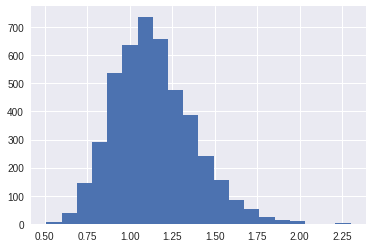

In [83]:
plt.hist(rho, bins=20)

#### $\alpha$ の事後分布
データを生成したガウシアンプロセスサンプラーは $1.0$ を設定していたのでした。

(array([ 30., 208., 554., 808., 810., 713., 511., 335., 224., 136.,  71.,
         53.,  20.,  16.,   7.,   1.,   0.,   0.,   2.,   1.]),
 array([0.593113  , 0.72936973, 0.86562646, 1.00188319, 1.13813992,
        1.27439666, 1.41065339, 1.54691012, 1.68316685, 1.81942358,
        1.95568031, 2.09193704, 2.22819377, 2.3644505 , 2.50070723,
        2.63696396, 2.77322069, 2.90947743, 3.04573416, 3.18199089,
        3.31824762]),
 <a list of 20 Patch objects>)

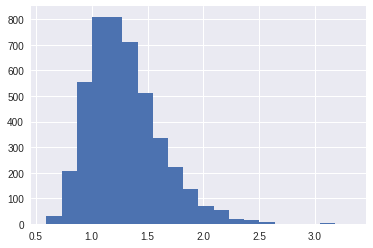

In [84]:
plt.hist(alpha, bins=20)

#### $\sigma$ の事後分布
データを生成したガウシアンプロセスサンプラーは $0.3$ を設定していたのでした。
少し高めに出ているように見えますね。

(array([  7.,  59., 209., 437., 720., 794., 792., 600., 385., 245., 125.,
         60.,  32.,  21.,   8.,   5.,   0.,   0.,   0.,   1.]),
 array([0.40476331, 0.43638268, 0.46800205, 0.49962142, 0.5312408 ,
        0.56286017, 0.59447954, 0.62609892, 0.65771829, 0.68933766,
        0.72095704, 0.75257641, 0.78419578, 0.81581516, 0.84743453,
        0.8790539 , 0.91067328, 0.94229265, 0.97391202, 1.00553139,
        1.03715077]),
 <a list of 20 Patch objects>)

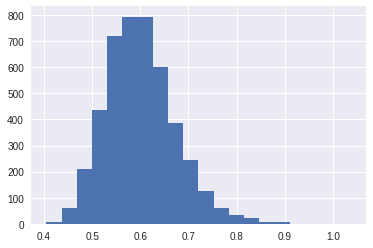

In [86]:
plt.hist(sigma, bins=20)